# Problématique

<h3> Prédire le mot dans l'image (régression)</h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [44]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss


In [22]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)

<module 'ressources' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\ressources.py'>

In [3]:
# BIDOUILLE SALE!! pour importer des fichiers qui ne sont pas dans le meme repertoire. les fichiers devront être mieux rangés par la suite
# import sys
# sys.path.insert(1, '../')

# import preprocessing as pp
# import ressources as rss

# Chargement du dataframe

In [26]:
# initialisation des variables globales
rss.init()

word_df = pd.DataFrame(pp.parse_my_word_file(rss.WORDS_META_FILENAME), columns=rss.WORD_COLUMNS)
word_df = pp.prepro_word(word_df)

d:\GitHub\OCRpyMAN\notebooks\letter_detection\..\preprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['word_img_path'] = word_df['word_id'].apply(lambda x: get_word_image_path_by_word_id(x))
d:\GitHub\OCRpyMAN\notebooks\letter_detection\..\preprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['form_img_path'] = word_df['word_id'].apply(lambda x: get_form_img_path_by_word_id(x))


Problème indice 3600
Problème indice 94929
Certains fichiers des mots sont inaccessibles : on les retire du dataframe


In [27]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    img_size=img_size,
    pickle_name="test",
    with_edge_detection = False
)
data_edge = ld_util.get_dataframe_with_preprocessed_imgs(
    img_size=img_size,
    load_pickle_if_exists = False,
    pickle_name="test_edge",
    with_edge_detection = True
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

df_edge = data_edge['df']
preprocessed_imgs_edge = data_edge['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Generating data...
Filtering data: taking only letters
Using 1000 rows
Starting preprocessing of images with tensorflow
Creating pickle dump ../pickle/test.pickle
Generating data...
Filtering data: taking only letters
Using 1000 rows
Starting preprocessing of images with tensorflow
Creating pickle dump ../pickle/test_edge.pickle
Length:  1000
Imgs length:  1000
Img shape:  (4096,)


In [28]:
print(len(df_edge))
print(len(preprocessed_imgs_edge))
print(len(df))
print(len(preprocessed_imgs))

1000
1000
1000
1000


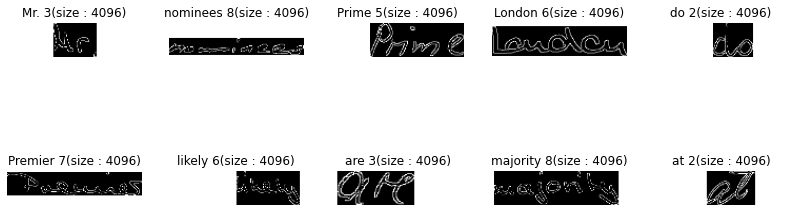

In [34]:

# j = 1
# random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs), size=[10])
# plt.figure(figsize=(14, 5))
# for i in random_indexes:
#     plt.subplot(2, 5, j)
#     plt.axis('off')
#     plt.imshow(preprocessed_imgs[i].reshape(img_size), cmap='gray');
#     plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length))
#     j+=1
    
j = 1
random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs_edge), size=[10])
plt.figure(figsize=(14, 5))
for i in random_indexes:
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(preprocessed_imgs_edge[i].reshape(img_size), cmap='gray');
    plt.title(df_edge.iloc[i].transcription + ' ' + str(df_edge.iloc[i].length) + '(size : ' + str(len(preprocessed_imgs_edge[i])) + ')')
    j+=1

# Model